In [14]:
%matplotlib inline
from __future__ import division, print_function
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import os
np.set_printoptions(suppress=True) #小数点表示とする
np.set_printoptions(precision=3) #小数点第三位までとする

In [196]:
import os
import cv2 as cv
import six.moves.cPickle as pickle
import numpy as np
import math

train = []
test = []
train_cls = []
test_cls = []
dic = []
dic_ = []
dic_cls = []
IMG_PATH = "./merge/characters/"
dn=0

tmp = os.listdir(IMG_PATH)
# 学習画像の選択（>=500）
for d in tmp:
    if not d.startswith("U+"):
        continue
    tmp2 = os.listdir(IMG_PATH+d)
    dic.append(d)
        
dic_cls = range(len(dic))
dic_cls = map(lambda x: x+1, dic_cls)
dic = dict(zip(dic,dic_cls))
tmp =map(lambda x:unichr(int(x.replace("U+",""),16)),dic)
dic2 = dict(zip(dic.values(),tmp))
pickle.dump((dic,dic2), open("dic_full.pkl", 'wb'), -1)

In [35]:
tmp = os.listdir(IMG_PATH)
for d in tmp:
    if not d.startswith("U+"):
        continue
    if(not dic.has_key(d)):
        continue
    tmp2 = os.listdir(IMG_PATH+d)
    # 85% train 15% test
    tmp_data = []
    tmp_cls = []
    for f in tmp2:
        image = cv.imread(IMG_PATH+d+"/"+f)
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        image = cv.resize(image, (32, 32))
        image = image/255.0
        tmp_data.append(image)
        tmp_cls.append(dic[d])
    if len(tmp_data)==1:
        train.extend(tmp_data)
        test.extend(tmp_data)
        train_cls.extend(tmp_cls)
        test_cls.extend(tmp_cls)
    else:
        train.extend(tmp_data[1:int(math.ceil(len(tmp_data)*0.85))])
        test.extend(tmp_data[int(math.ceil(len(tmp_data)*0.85)):len(tmp_data)])
        train_cls.extend(tmp_cls[1:int(math.ceil(len(tmp_cls)*0.85))])
        test_cls.extend(tmp_cls[int(math.ceil(len(tmp_cls)*0.85)):len(tmp_cls)])    

train = np.array(train, np.float32)
test = np.array(test, np.float32)
train_cls = np.array(train_cls, np.int32)
test_cls = np.array(test_cls, np.int32)
pickle.dump((train,train_cls,test,test_cls), open("datasetfull_mono20161122.pkl", 'wb'), -1)

In [36]:
train,train_cls,test,test_cls = pickle.load(open("datasetfull_mono20161122.pkl","rb"))

In [37]:
train.shape

(72695, 32, 32)

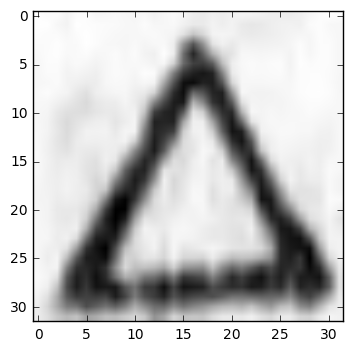

In [38]:
import matplotlib.pyplot as plt

plt.imshow(train[1],cmap='Greys_r')

In [39]:
test.shape

(12730, 32, 32)

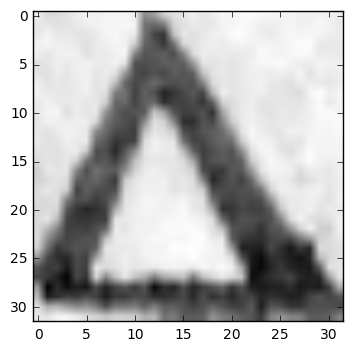

In [40]:
plt.imshow(test[1],cmap='Greys_r')

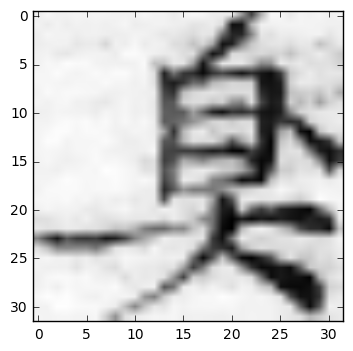

In [41]:
plt.imshow(train[len(train)-1],cmap='Greys_r')

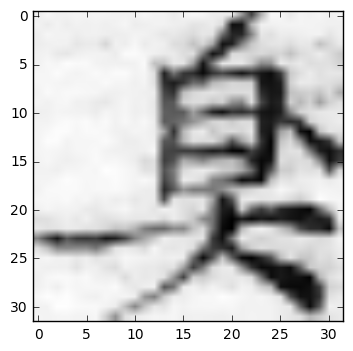

In [42]:
plt.imshow(test[len(test)-1],cmap='Greys_r')

In [43]:
x_train = train.reshape(train.shape+(1,))
x_test = test.reshape(test.shape+(1,))

In [44]:
x_train.shape

(72695, 32, 32, 1)

In [45]:
x_train[1].shape

(32, 32, 1)

In [46]:
y_train = to_categorical(train_cls)
y_test = to_categorical(test_cls)

In [47]:
y_train

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [48]:
model = Sequential()
model.add(Convolution2D(96, 3, 3, border_mode='same', input_shape=x_train[1].shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 2, 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(dic)+1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 32, 32, 96)    960         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 32, 32, 96)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 31, 31, 32)    12320       activation_13[0][0]              
____________________________________________________________________________________________________
activation_14 (Activation)       (None, 31, 31, 32)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

In [50]:
model.fit(x_train, y_train, batch_size=128, nb_epoch=200, verbose=1,validation_data=(x_test,y_test))

Train on 72695 samples, validate on 12730 samples
Epoch 1/200
72695/72695 [==============================] - 642s - loss: 4.5294 - acc: 0.1618 - val_loss: 3.6268 - val_acc: 0.2749
Epoch 2/200
72695/72695 [==============================] - 653s - loss: 2.9657 - acc: 0.3995 - val_loss: 3.0349 - val_acc: 0.3837
Epoch 3/200
72695/72695 [==============================] - 647s - loss: 2.3909 - acc: 0.5013 - val_loss: 2.6198 - val_acc: 0.4596
Epoch 4/200
72695/72695 [==============================] - 645s - loss: 2.0520 - acc: 0.5611 - val_loss: 2.5403 - val_acc: 0.4739
Epoch 5/200
72695/72695 [==============================] - 649s - loss: 1.8026 - acc: 0.6061 - val_loss: 2.3231 - val_acc: 0.5198
Epoch 6/200
72695/72695 [==============================] - 2953s - loss: 1.6212 - acc: 0.6394 - val_loss: 1.9999 - val_acc: 0.5815
Epoch 7/200
72695/72695 [==============================] - 683s - loss: 1.4811 - acc: 0.6625 - val_loss: 1.9625 - val_acc: 0.5827
Epoch 8/200
72695/72695 [==============

In [51]:
model.save("model20161122.h5")

In [41]:
from keras.models import load_model
model = load_model('./model20161122.h5')

## 評価

In [43]:
x_test = test
x_test.shape

(12730, 32, 32)

In [44]:
y_test = to_categorical(test_cls)

In [56]:
evaluation = model.evaluate(x_test,y_test)

12730/12730 [==============================] - 53s    


In [57]:
print('Test loss :', evaluation[0])
print('Test accuracy :', evaluation[1])

Test loss : 1.11654221829
Test accuracy : 0.792223095089


## 簡易チェック

1/1 [==============================] - 0s
が


u'\u304c'

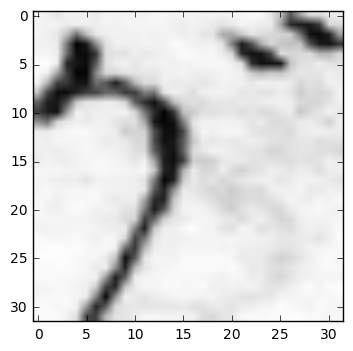

In [216]:
image = cv.imread("u304c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
x.shape
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
で


u'\u3067'

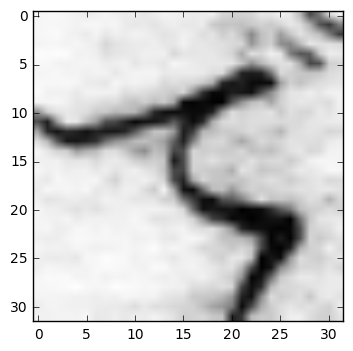

In [217]:
image = cv.imread("u3067_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
ど


u'\u3069'

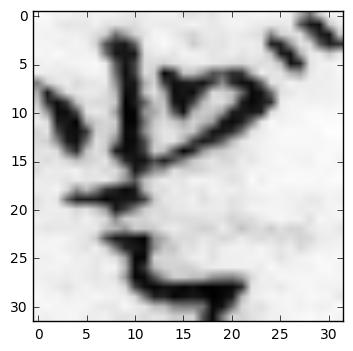

In [218]:
image = cv.imread("u3069_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
に


u'\u306b'

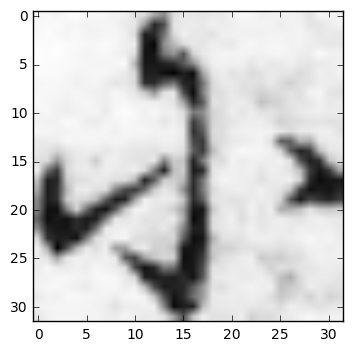

In [219]:
image = cv.imread("u306b_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
ば


u'\u3070'

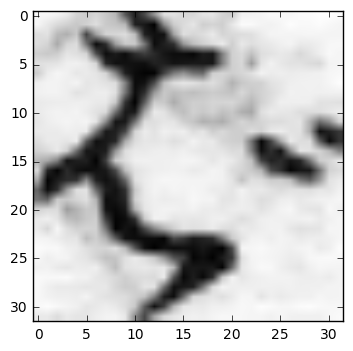

In [220]:
image = cv.imread("u3070_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
升


u'\u5347'

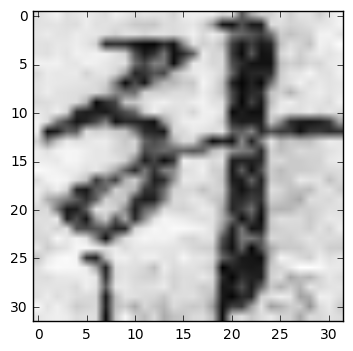

In [221]:
image = cv.imread("u5347_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
同


u'\u540c'

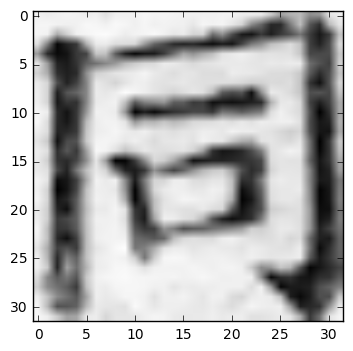

In [222]:
image = cv.imread("u540c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
色


u'\u8272'

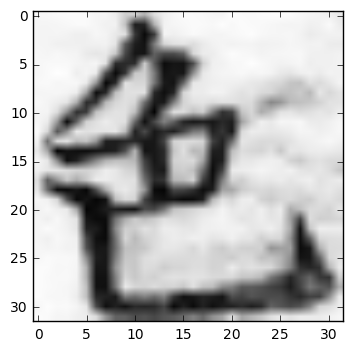

In [223]:
image = cv.imread("u8272_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
酒


u'\u9152'

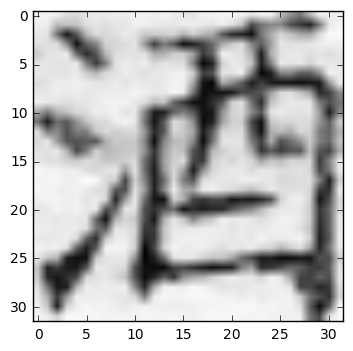

In [224]:
image = cv.imread("u9152_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]

1/1 [==============================] - 0s
ぼ


u'\u307c'

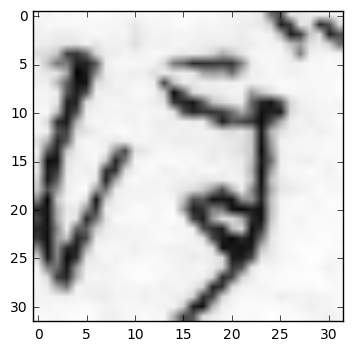

In [225]:
image = cv.imread("u307c_00.jpg")
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image = cv.resize(image, (32, 32))
plt.imshow(image, cmap='Greys_r')
image
image = image/255.0
x=np.array(image,np.float32)
x=x.reshape((1,)+x.shape+(1,))
labels_pred = model.predict_classes(x,verbose=1)
print(dic2[labels_pred[0]])
dic2[labels_pred[0]]